# Multiphoton

- Multiphoton absorption

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 18

In [2]:
from IPython.display import Image
from IPython.display import Math
from IPython.display import Latex

In [3]:
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Tue Jun 18 10:44:24 2019


In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tables            as tb
import random
import glob
import warnings
sns.set()

In [5]:
from  invisible_cities.core.system_of_units import *

In [6]:
from sabat.sbt_types import FoV, CircularFoV, Monolayer
from sabat.sbt_types import Laser, PulsedLaser, GLaser, GaussianBeam
from sabat.sbt_types import Molecule
from sabat.sbt_types import Molecule2P
from sabat.sbt_types import DyeSample
from sabat.sbt_types import Microscope
from sabat.sbt_types import CCD
from sabat.sbt_types import PhotonsPerSample

In [7]:
from sabat.sbt_core import  power_density
from sabat.sbt_core import  photon_density
from sabat.sbt_core import  fluorescence_per_molecule
from sabat.sbt_core import  duration_of_fluorescence
from sabat.sbt_core import  diffraction_limit
from sabat.sbt_core import  photoelectrons_per_pixel
from sabat.sbt_core import  absorbed_photons_per_fluorophore_per_pulse_2p
from sabat.sbt_core import  fluorescence_2p_gb
from sabat.sbt_core import  fluorescence_2p_dl
from sabat.sbt_core import  fluorescence_dl_2p
from sabat.sbt_core import  fluorescence_dl
from sabat.sbt_core import  photon_per_sample
from sabat.sbt_core import  signal

In [8]:
from sabat.sbt_types import  photon, molecule, GM, us, ucm2, ucm3, gp 

In [9]:
from sabat.sbt_core  import  FIB 
from sabat.sbt_core  import  FLUO3
from sabat.sbt_core import  Setup

In [10]:
GM3 = 1e-83 * cm**6*second**2

In [11]:
def set_fonts(ax, fontsize=20):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)


# Relevant papers
https://www.osapublishing.org/boe/abstract.cfm?uri=boe-5-10-3427

## Author

- J.J. Gomez-Cadenas [NEXT](https://next.ific.uv.es/next/) 

#### Contact


- [Email](mailto:jjgomezcadenas@dipc.org)




## Multi Photon Absorption

Multi-photon absorption (nPA) is the physical process by which n (n=2,3...) photons of identical or different frequencies are absorbed by a molecule. The energy difference between the involved lower and upper states of the molecule equals  the sum of the energies of the two photons absorbed. nPA is a high-order process, typically several orders of magnitude weaker than linear absorption at low light intensities. In MPA the transition rate depends on I^n, where I is the intensity. The non-linear nature of the process can make MPA dominate over linear absorption at high intensities.

Two-photon absorption can lead to n-photon-excited fluorescence (nPEF) where the excited state produced by nPA decays by spontaneous emission to a lower energy state 

<img align="center" src="img/TPEM.png" width="500" height="500"></img>



In n-photon excitation microscopy (nPEM) a pulsed laser beam (often infrared, since many common dyes absorb in the blue) is focused through an objective lens. The  laser pulse width is in the range of 100 femtoseconds and the repetition rate in the range of 100 MHz, allowing the high photon density and flux required for two photons absorption


## Mathematical formulation

The emitted fluorescence is:

\begin{equation}
F^{(n)} (t) = \frac{1}{n} \frac{g_p^{(n)}}{(f \tau)^{n-1}} \frac{\epsilon Q C \sigma^{(n)} n_0 a^{(n)} A^{2n-4} P(t)^n}{8 \pi^{3-n} \lambda^{2n-3}} 
\end{equation}

Where $n$ is the number of photons absorbed, $g_p^{(n)}$ is the nth order temporal coherence of the excitation source, $a^{(n)}$ is a numerical constant, $f$ is the laser repetition rate (tipically 100 MHz), $\tau$ is the laser pulse width FWHM (100 fs), $\epsilon$ is the overall transmission efficiency of the setup, $Q$ is the quantum field of the molecule, $C$ the concentration, $\sigma^{(n)}$ the cross section for n-photon absorption, $A$ the numerical aperture of the setup, and $P$ the power.

For n = 2: 

- $\sigma^{(2)} = 32.8 \, 10^{-50} cm^4/(s\, photon)$ for Fluorescein at 800 nm
- $g_p^{(2)} = 0.664$
- $a^{(2)} = 64$

For n = 3:

- $\sigma^{(3)} = 16.3 \, 10^{-84} cm^6/(s\, photon)^2$ for Fluorescein at 1300 nm
- $g_p^{(3)} = 0.51$
- $a^{(2)} = 28.1$


## 2PA and 3PA for FIB

- Assume same order of magnitude cross sections than for Fluorescein

In [12]:
fib = FIB(Q=0.4)
fib


        FIB:
        sigma2  (500 nm)  = 25.9 GM
        sigma3  (500 nm)  =1.0e+00 GM3
        Q                 =4.0e-01

        

### Laser beam
- Compare the 2PA (at 500 nm) with 3PA (at 800 nm)
- Cross sections are just orders of magnitude.

In [13]:
lb2 = PulsedLaser(lamda=500*nm, power=500*mW, f=100*MHZ, tau=100*femtosecond)  
lb2


        Pulsed Laser:
        wavelength                =5.0e+02 nm
        photon energy             =2.5e+00 eV
        power                     =5.0e+02 mW
        repetition rate           =1.0e+02 kHz
        pulse width               =1.0e+02 fs
        energy per pulse          =5.0e+04 fJ
        energy per second         =5.0e+02 mJ
        photons per second        =1.3e+18 ph/second
        

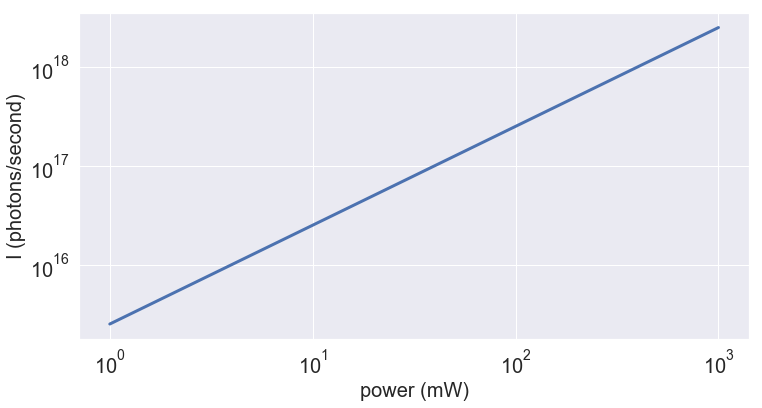

In [14]:
P  = np.linspace(1,1001) 
LB2 =[PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
FF2 =np.array([lb.n_photons() for lb in LB2])

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.loglog(P, FF2/us, linewidth=3)
plt.xlabel(r"power (mW)")
plt.ylabel("I (photons/second)")
plt.grid(True)

In [15]:
lb3 = PulsedLaser(lamda=750*nm, power=3000*mW, f=100*MHZ, tau=100*femtosecond)  
lb3


        Pulsed Laser:
        wavelength                =7.5e+02 nm
        photon energy             =1.7e+00 eV
        power                     =3.0e+03 mW
        repetition rate           =1.0e+02 kHz
        pulse width               =1.0e+02 fs
        energy per pulse          =3.0e+05 fJ
        energy per second         =3.0e+03 mJ
        photons per second        =1.1e+19 ph/second
        

### Microscope: define first a microscope with transmission = 1

In [16]:
mci = Microscope(name='Ideal', numerical_aperture=1.4, magnification=100,  
                eff_PMT = 1, eff_dichroic = 1, eff_filter = 1) 
print(mci)


        name                 = Ideal
        NA                   = 1.4e+00
        M                    = 1.0e+02
        eff dichroic         = 1.00e+00
        eff filter           = 1.00e+00
        eff PMT              = 1.00e+00
        Optical transmission = 5.00e-01
        Filter  transmission = 1.00e+00
        Total transmission   = 5.00e-01
        


### And now a realistic microscope

In [17]:
mc = Microscope(name='Espinardo', numerical_aperture=0.5, magnification=20,  
                eff_PMT = 0.1, eff_dichroic = 0.85, eff_filter = 0.8) 
print(mc)


        name                 = Espinardo
        NA                   = 5.0e-01
        M                    = 2.0e+01
        eff dichroic         = 8.50e-01
        eff filter           = 8.00e-01
        eff PMT              = 1.00e-01
        Optical transmission = 9.19e-02
        Filter  transmission = 6.80e-01
        Total transmission   = 4.25e-03
        


### FOV at diffraction limit Ideal microscope. 

In [24]:
dl2 = diffraction_limit(lb2, mci)
dl3 = diffraction_limit(lb3, mci)
print(f' diffraction limit for 500 nm = {dl2/micron}')
print(f' diffraction limit for 750 nm = {dl3/micron}')

 diffraction limit for 500 nm = 0.2178571428571429
 diffraction limit for 750 nm = 0.32678571428571435


In [26]:
fov= CircularFoV(d = dl2, z= 2 * dl2)
fov


        FOV; d = 2.2e-04 mm; r = 1.1e-04 mm; z = 4.4e-04 mm;
        area = 3.7e-08 mm2 volume = 1.6e-11 mm3
        

### Density of photons in that area

In [27]:
I = photon_density(lb2, fov)
print(f'photon density = {I/(us*ucm2):5.1e} photons/(second cm2)')

photon density = 3.4e+27 photons/(second cm2)


In [28]:
print(f'photon density per pulse= {I/lb2.tau/(us*ucm2):5.1e} photons/(second cm2)')

photon density per pulse= 3.4e+31 photons/(second cm2)


In [128]:
GM = 1e-50 * cm2*cm2*second / (photon * molecule)
uml = nm**4 * 1e-8 * second
GM/uml

9.999999999999994e-15

### FOV realistic microscope

In [129]:
ui = nm**2 * 1e-8 * second
I/ui

3.37578090601872e+27

In [29]:
rdl2 = diffraction_limit(lb2, mc)
rdl3 = diffraction_limit(lb3, mc)
print(f' diffraction limit for 500 nm = {rdl2/micron}')
print(f' diffraction limit for 750 nm = {rdl3/micron}')

 diffraction limit for 500 nm = 0.6100000000000001
 diffraction limit for 750 nm = 0.9150000000000001


In [30]:
rfov= CircularFoV(d = rdl2, z= 2 * rdl2)
rfov


        FOV; d = 6.1e-04 mm; r = 3.1e-04 mm; z = 1.2e-03 mm;
        area = 2.9e-07 mm2 volume = 3.6e-10 mm3
        

In [31]:
rI = photon_density(lb2, rfov)
print(f'photon density = {rI/(us*ucm2):5.1e} photons/(second cm2)')

photon density = 4.3e+26 photons/(second cm2)


In [32]:
print(f'photon density per pulse= {rI/lb2.tau/(us*ucm2):5.1e} photons/(second cm2)')

photon density per pulse= 4.3e+30 photons/(second cm2)


In [ ]:
uns = 1 / ns
unm

In [ ]:
print(f'photon density per pulse= {rI/lb2.tau/(us*ucm2):5.1e} photons/(second cm2)')

### Dye 

In [36]:
ds = DyeSample(name='f2p',concentration = 1000/6 * nanomole/liter, volume= fov.volume())
ds


        Dye name =f2p;
        concentration = 1.7e-07 mole/l (1.0e+14 molecules/cm3);
        V = 1.6e-17 l,
        nof molecules = 1.6e+00
        

In [37]:
rds = DyeSample(name='rf2p',concentration = 50/6 * nanomole/liter, volume= rfov.volume())
rds


        Dye name =rf2p;
        concentration = 8.3e-09 mole/l (5.0e+12 molecules/cm3);
        V = 3.6e-16 l,
        nof molecules = 1.8e+00
        

### Fluorescence

#### 2p for 500 nm

In [48]:
F2 = fluorescence_dl(ds, fib, lb2, mci, n_photons = 2, verbose = True)

 number of photons absorbed =2
 Q = 0.4, sigma ( 500.00) =   25.92 GM
 rho = 1.0e+14 molecules/cm3
 f * tau = 1.0e-05
 photons/second = 1.3e+09
 t1 =  C * sigma * P^2 / lamda = 8.2e+05 s
 t2 = gp/(f tau) = 6.6e+04
 t3 = A * Q = 5.1e-01
 microscope T = 5.0e-01


In [63]:
print(f'number of molecules in fov ={ds.n_molecules()}')
print(f' Fluorescence = {F2/us:5.1e} photons/second')
print(f' Fluorescence per molecule = {F2/ds.n_molecules()/us:5.1e} photons/second')

number of molecules in fov =1.6304102644387732
 Fluorescence = 1.4e+10 photons/second
 Fluorescence per molecule = 8.5e+09 photons/second


In [86]:
F2s = fluorescence_dl_2p(ds, fib, lb2, mci, verbose = True)
print(f' Fluorescence (saturates at na = 2) {F2s/us:5.1e} photons/second')

 Fluorescence (saturates at na = 2) 5.0e+07 photons/second


#### 3p for 800 nm

In [87]:
F3 = fluorescence_dl(ds, fib, lb3, mci, n_photons = 3, verbose = True)

 number of photons absorbed =3
 Q = 0.4, sigma ( 750.00) =    1.00 GM
 rho = 1.0e+14 molecules/cm3
 f * tau = 1.0e-05
 photons/second = 1.1e+10
 t1 =  C * sigma * P^2 / lamda = 3.5e+00 s
 t2 = gp/(f tau) = 5.1e+09
 t3 = A * Q = 9.2e-01
 microscope T = 5.0e-01


In [88]:
print(f' F3 = {F3/us:5.1e} photons/second')

 F3 = 8.1e+09 photons/second


### Fluorescence for an ideal microscope (T=1, NA=1.4) and "standard" setup (100 MHz, 100 fs)

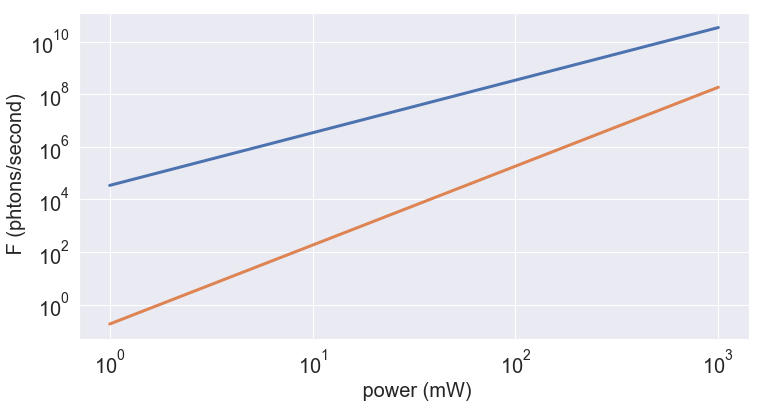

In [65]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)
P  = np.linspace(1,1001) 
LB2 =[PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
LB3 =[PulsedLaser(lamda=750*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
FF2 =np.array([fluorescence_dl(ds, fib, lb, mci, n_photons = 2) / ds.n_molecules() for lb in LB2])
FF3 =np.array([fluorescence_dl(ds, fib, lb, mci, n_photons = 3) / ds.n_molecules() for lb in LB3])

set_fonts(ax, fontsize=20)

plt.loglog(P, FF2/us, linewidth=3)
plt.loglog(P, FF3/us, linewidth=3)
plt.xlabel(r" power (mW)")
plt.ylabel(" F (phtons/second)")
plt.grid(True)


### Fluorescence for realistic microscope

In [66]:
rF2 = fluorescence_dl(rds, fib, lb2, mc, n_photons = 2, verbose = True)

 number of photons absorbed =2
 Q = 0.4, sigma ( 500.00) =   25.92 GM
 rho = 5.0e+12 molecules/cm3
 f * tau = 1.0e-05
 photons/second = 1.3e+09
 t1 =  C * sigma * P^2 / lamda = 4.1e+04 s
 t2 = gp/(f tau) = 6.6e+04
 t3 = A * Q = 5.1e-01
 microscope T = 4.2e-03


In [67]:
print(f'number of molecules in fov ={rds.n_molecules()}')
print(f' Fluorescence = {rF2/us:5.1e} photons/second')
print(f' Fluorescence per molecule = {rF2/rds.n_molecules()/us:5.1e} photons/second')

number of molecules in fov =1.7895383062479977
 Fluorescence = 5.9e+06 photons/second
 Fluorescence per molecule = 3.3e+06 photons/second


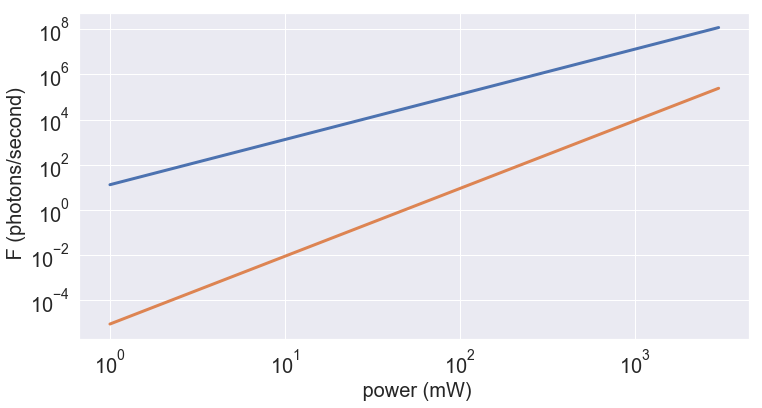

In [69]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)
P  = np.linspace(1,3001) 
LB2 =[PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
LB3 =[PulsedLaser(lamda=750*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
FF2 =np.array([fluorescence_dl(rds, fib, lb, mc, n_photons = 2) / rds.n_molecules() for lb in LB2])
FF3 =np.array([fluorescence_dl(rds, fib, lb, mc, n_photons = 3) / rds.n_molecules() for lb in LB3])

set_fonts(ax, fontsize=20)

plt.loglog(P, FF2/us, linewidth=3)
plt.loglog(P, FF3/us, linewidth=3)
plt.xlabel(r" power (mW)")
plt.ylabel(" F (photons/second)")
plt.grid(True)


### According to calculation a large number of fluorescence photons are produced even for small concentrations

## Number of absorbed photons, per fluorophere per pulse

http://www.aomf.ca/pdfs/Denk1990.pdf

- equation 9 (in references)

$$ na = \frac{P^2 Q \sigma_2}{\tau f} (\frac{A^2}{2 \hbar c \lambda})^2$$ (8)

where:
- Q is the quantum efficiency (0.9 for fluorescein)
- $\sigma_2$ is the two photon absorption cross section (in cm$^4$ s)
- A is the numerical aperture
- f is the frequency (e.g, 80 MHZ)
- $\tau$ is the FWHM of the pulse width (e.g, 400 fs)
- P is the laser power
- $\lambda$ is the wavelength of the light

- units are photons/fluorophene


In [72]:
na = absorbed_photons_per_fluorophore_per_pulse_2p(fib, lb2, mci)

In [73]:
print(f' number of absorbed photons per fluorophore per pulse = {na:5.1e}')

 number of absorbed photons per fluorophore per pulse = 1.0e+03


### Thus the laser saturates the molecule in each pulse. The number of emitted photons is simply the number of pulses

In [43]:
n_f = n_pulses_per_second = lb.f/hertz
print(f' number of produced photons per fluorophore per second = {n_pulses_per_second:5.1e}')

 number of produced photons per fluorophore per second = 1.0e+08


In [74]:
rna = absorbed_photons_per_fluorophore_per_pulse_2p(fib, lb2, mc)
print(f' number of absorbed photons per fluorophore per pulse = {rna:5.1e}')

 number of absorbed photons per fluorophore per pulse = 1.6e+01


### It saturates also for realistic microscope

In [93]:
N = []
P = np.linspace(50,200,10)
for p in P:
    lb = PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond)  
    na = absorbed_photons_per_fluorophore_per_pulse_2p(fib, lb, mc)
    N.append(na)

Text(0, 0.5, '# photons absorbed')

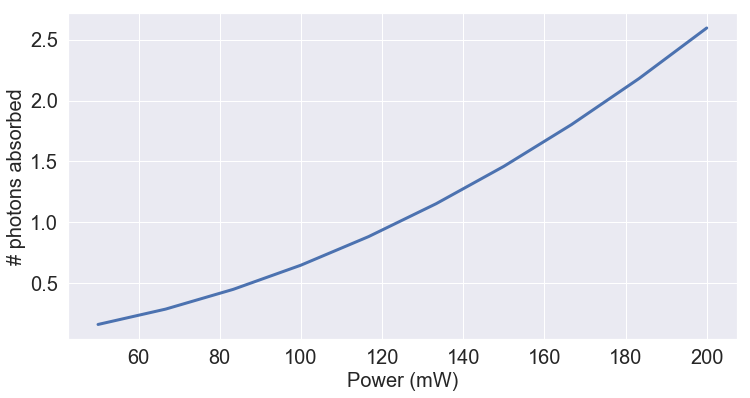

In [94]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
plt.plot(P, N, linewidth=3)
plt.xlabel('Power (mW)')
plt.ylabel('# photons absorbed')

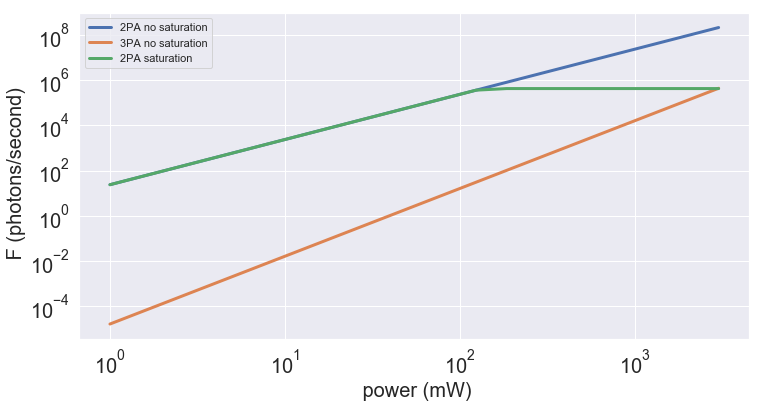

In [118]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)
P  = np.linspace(1,3001) 
LB2 =[PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
LB3 =[PulsedLaser(lamda=750*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
FF2 =np.array([fluorescence_dl(rds, fib, lb, mc, n_photons = 2)  for lb in LB2])
FF3 =np.array([fluorescence_dl(rds, fib, lb, mc, n_photons = 3)  for lb in LB3])
FF4 =np.array([fluorescence_dl_2p(rds, fib, lb, mc)              for lb in LB2])

set_fonts(ax, fontsize=20)

plt.loglog(P, FF2/us, linewidth=3, label='2PA no saturation')
plt.loglog(P, FF3/us, linewidth=3, label='3PA no saturation')
plt.loglog(P, FF4/us, linewidth=3, label='2PA saturation')
plt.xlabel(r" power (mW)")
plt.ylabel(" F (photons/second)")
plt.legend()
plt.grid(True)

### A better microscope is possible:

In [119]:
mcr = Microscope(name='NEXT', numerical_aperture=1.5, magnification=20,  
                eff_PMT = 0.5, eff_dichroic = 0.95, eff_filter = 0.95) 
print(mcr)


        name                 = NEXT
        NA                   = 1.5e+00
        M                    = 2.0e+01
        eff dichroic         = 9.50e-01
        eff filter           = 9.50e-01
        eff PMT              = 5.00e-01
        Optical transmission = 5.00e-01
        Filter  transmission = 9.02e-01
        Total transmission   = 2.04e-01
        


In [120]:
pdl2 = diffraction_limit(lb2, mcr)
print(f' diffraction limit for 500 nm = {pdl2/micron}')
pfov= CircularFoV(d = pdl2, z= 2 * pdl2)
pds = DyeSample(name='pf2p',concentration = 1000/6 * nanomole/liter, volume= pfov.volume())
pds

 diffraction limit for 500 nm = 0.20333333333333337



        Dye name =pf2p;
        concentration = 1.7e-07 mole/l (1.0e+14 molecules/cm3);
        V = 1.3e-17 l,
        nof molecules = 1.3e+00
        

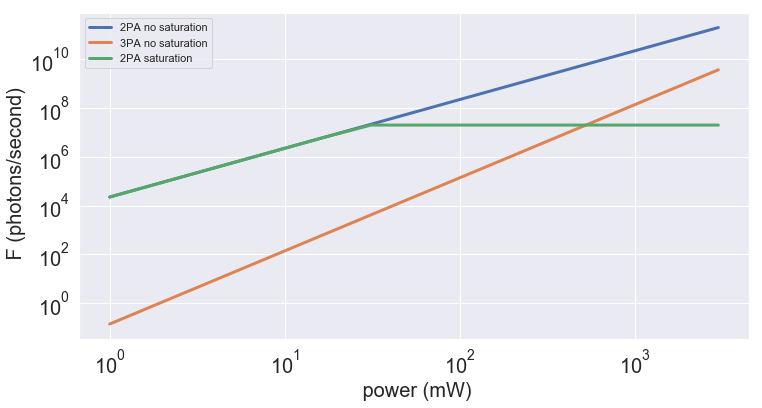

In [121]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)
P  = np.linspace(1,3001,200) 
LB2 =[PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
LB3 =[PulsedLaser(lamda=750*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
FF2 =np.array([fluorescence_dl(pds, fib, lb, mcr, n_photons = 2)  for lb in LB2])
FF3 =np.array([fluorescence_dl(pds, fib, lb, mcr, n_photons = 3)  for lb in LB3])
FF4 =np.array([fluorescence_dl_2p(pds, fib, lb, mcr)              for lb in LB2])

set_fonts(ax, fontsize=20)

plt.loglog(P, FF2/us, linewidth=3, label='2PA no saturation')
plt.loglog(P, FF3/us, linewidth=3, label='3PA no saturation')
plt.loglog(P, FF4/us, linewidth=3, label='2PA saturation')
plt.xlabel(r" power (mW)")
plt.ylabel(" F (photons/second)")
plt.legend()
plt.grid(True)

### Ideal microscope

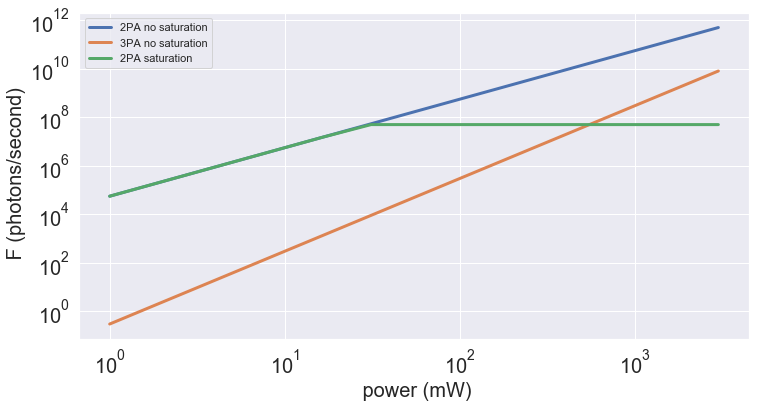

In [122]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)
P  = np.linspace(1,3001,200) 
LB2 =[PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
LB3 =[PulsedLaser(lamda=750*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
FF2 =np.array([fluorescence_dl(ds, fib, lb, mci, n_photons = 2)  for lb in LB2])
FF3 =np.array([fluorescence_dl(ds, fib, lb, mci, n_photons = 3)  for lb in LB3])
FF4 =np.array([fluorescence_dl_2p(ds, fib, lb, mci)              for lb in LB2])

set_fonts(ax, fontsize=20)

plt.loglog(P, FF2/us, linewidth=3, label='2PA no saturation')
plt.loglog(P, FF3/us, linewidth=3, label='3PA no saturation')
plt.loglog(P, FF4/us, linewidth=3, label='2PA saturation')
plt.xlabel(r" power (mW)")
plt.ylabel(" F (photons/second)")
plt.legend()
plt.grid(True)

In [124]:
print(f' 2PA no saturation. Max fluorescence: {FF2[-1]/us:5.1e}')
print(f' 2PA    saturation. Max fluorescence: {FF4[-1]/us:5.1e}')
print(f' 3PA no saturation. Max fluorescence: {FF3[-1]/us:5.1e}')

 2PA no saturation. Max fluorescence: 5.0e+11
 2PA    saturation. Max fluorescence: 5.0e+07
 3PA no saturation. Max fluorescence: 8.1e+09


# Monolayer

## Signal to noise

- Consider a monolayer spot iluminated by the laser. The spot contains $m$ molecules, of which one molecule is chelated. 
- The number of photons emited by the chelated molecule as a response to the laser pulse will be distributed around $n_p$, where $n_p$ is computed from $n_a$ (equation 8), $n_f = n_a/2)$. Notice that if $n_a$ is larger than 2 (the number of photons that the molecule can absorbe per pulse) then $n_p = 1$. 
- The fluorescence emitted in a given time interval by the chelated molecules will be $n_f$. In a second, with a 100 MHz laser and in the absence of photobleaching, $n_f = 10^8$. 
- The remaining molecules ($m -1 \sim m$, since $m$ is large) will emit (per molecule, in average) $n_f/\alpha$, where $\alpha$ is the ratio of fluorescence between chelated and unchelated molecules (e.g, $\alpha  \sim 100$ for FIB). The total fluorescence emitted by the background molecules will therefore be distributed around $n_b = \frac{n_f \,m}{\alpha}$.
- The signal to noise ration (SNR) is simply:

$$SNR = \frac{n_f}{\sqrt{n_b}} = \frac{n_f}{\sqrt{\frac{n_f \, m}{\alpha}}} = \sqrt{\frac{n_f\, \alpha}{m}} $$

In terms of the number of detected photons we need to multiply by the detection efficiency $\epsilon$. 

$$SNR =  \sqrt{\epsilon \frac{n_f\, \alpha}{m}} $$

In [130]:
print(f' number of absorbed photons per fluorophore per pulse = {na:5.1e}')

 number of absorbed photons per fluorophore per pulse = 2.6e+00


#### This is exactly what is needed to saturate the fluorophore.

In [131]:
power_to_saturate_fluorescence = (2/na) *lb.power
print(f'power_to_saturate_fluorescence={power_to_saturate_fluorescence/mW:5.1e} mW')

power_to_saturate_fluorescence=1.5e+02 mW


### The number of photons per fluorophere per second should then simply be equal to the number of pulses, sice we saturate

In [132]:
n_f = n_pulses_per_second = lb.f/hertz
print(f' number of produced photons per fluorophore per second = {n_pulses_per_second:5.1e}')

 number of produced photons per fluorophore per second = 1.0e+08


## We can read the PMT at vr MHz

In [134]:
def readout_frq(vr : float = 100 * MHZ)->float:
    return 1./(vr/hertz)

In [135]:
readout_frq(vr  = 1 * hertz)

1.0

#### alpha is the molecule signal to ratio

In [136]:
alpha = 100 

In [138]:
nps = photon_per_sample(n_f, readout_frq(1 * hertz), alpha, mcr)
nps


        ns_ph = 1.0e+08 ; ns_det = 2.0e+07 ; nb_ph= 1.0e+06 ; nb_det = 2.0e+05
        

### Assuming detection efficiency = 1

In [139]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_ph, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 1.0e+08
        n_b               = 1.0e+06
        alpha (snr c/u)   = 1.0e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 1.0e+12
        snr               = 1.0e+02
        

### Taking into account the detection efficiency

In [141]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 2.0e+07
        n_b               = 2.0e+05
        alpha (snr c/u)   = 1.0e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 2.0e+11
        snr               = 4.5e+01
        

### Statistical test

run 1000 experiments in 25.546162843704224 seconds


(array([  2.,   5.,  47., 130., 252., 298., 183.,  67.,  15.,   1.]),
 array([11555976.55586243, 11811814.79977875, 12067653.04369507,
        12323491.28761139, 12579329.53152771, 12835167.77544403,
        13091006.01936035, 13346844.26327667, 13602682.50719299,
        13858520.75110931, 14114358.99502563]),
 <a list of 10 Patch objects>)

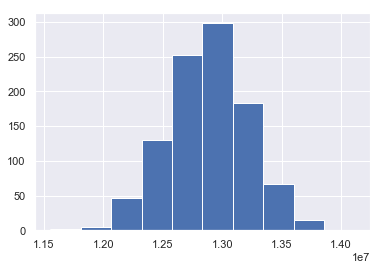

In [40]:
n  = int(1e+3)
t0 = time.time()
N = [ml.nsignal() for i in range(n)]
t1 = time.time()
print(f'run {n} experiments in {t1-t0} seconds')
plt.hist(N, bins=10)

In [41]:
np.average(N) / np.std(N)

38.080677590803944

In [42]:
n  = int(1e+3)
t0 = time.time()
N  = signal(ml, n_exp = n)
t1 = time.time()
print(f'run {n} experiments in {t1-t0} seconds')

run 1000 experiments in 25.00779700279236 seconds


(array([  5.,  19.,  46., 129., 241., 245., 185.,  96.,  30.,   4.]),
 array([0.90209252, 0.9207116 , 0.93933067, 0.95794975, 0.97656882,
        0.9951879 , 1.01380698, 1.03242605, 1.05104513, 1.0696642 ,
        1.08828328]),
 <a list of 10 Patch objects>)

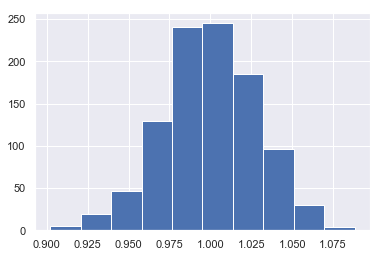

In [43]:
plt.hist(N, bins=10)

In [44]:
np.average(N) / np.std(N)

34.8021511643825

### In 100 ms

In [142]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det/10, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 2.0e+06
        n_b               = 2.0e+04
        alpha (snr c/u)   = 1.0e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 2.0e+10
        snr               = 1.4e+01
        

### In 10 ms

In [143]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det/100, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 2.0e+05
        n_b               = 2.0e+03
        alpha (snr c/u)   = 1.0e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 2.0e+09
        snr               = 4.5e+00
        

#### Thus one could get to 10 ms steps with a 100 MHz beam and in the absence of photobleaching. Ways to improve:
- Use a GHz laser (feasible).
- Use plasmonic amplification. 

#### Photobleaching
- Photobleaching (PB) will burn the molecule if it emits more than a given number of photons. 
- It appears that with 10^5 photons is possible to identify the molecule. Thus if PB is below that range, we are OK. 
- Notice that all molecules emit, so if PB occurs at low values of light emmission the scan would burn the target.
- PB for fluorescein occurs at 360,000 photons in deoxygenated environment.
- The FIB molecule will work in dry medium, with very small amounts of oxygen. The feasibility of the experiment depends of a PB level being sufficiently low, but that appears reasonable given the PB level of Fluorescein. 
- Alternatively plasmonic amplification could amplify the signal and avoid reaching PB criticality.

## Scanning time

- In a monolayer molecules will be packed at 1 nm separation. The ML itself will be 1 nm thick.
- Assume that the beam will illuminate a region of 1 mu2. 
- Then, if the mirror speed can be tuned to 1 khz, one could cover 1E+3 points per second. 
- Assuming that 1 ms exposure is enough, one can use an array of beams to cover the transverse coordinate.
- Using 20 beams, one needs 50 seconds to cover the 1 mm2 sample, which appears reasonable!
- If each point takes longer (e.g, above, 10 ms), one could still be OK (500 s scan is less than 10 minutes). 

# What about Single Photon Absorption (SPA)?

- One needs a fs  pulsed laser, rather than a CW laser. Otherwise the excess power (even more at 250 nm) will destroy the molecule. 
- No such lasers available for excitation in the UV (e.g, 250 nm)
- Not obvious how to focus SPA (can't use TIRF in dry medium).
- TPA seems preferred!

In [144]:
fl = Molecule(name = 'Fluorescein', sigma=3E-16 * cm2, Q=0.9)
fl


        Molecule name =Fluorescein; cross section = 3.0e-16 cm2; Q =   0.9
        

In [145]:
lb = Laser(lamda=488*nm, power=1 * mW)  
lb


        Laser:
        wavelength                =4.9e+02 nm
        photon energy             =2.5e+00 eV
        power                     =1.0e+00 mW
        energy per second         =1.0e+00 mJ
        photons per second        =2.5e+15 ph/second
        

In [146]:
mc = Microscope(name='UTA', numerical_aperture=1.0, magnification=20,  
                eff_PMT = 0.5, eff_dichroic = 0.95, eff_filter = 0.95) 
print(mc)


        name                 = UTA
        NA                   = 1.0e+00
        M                    = 2.0e+01
        eff dichroic         = 9.50e-01
        eff filter           = 9.50e-01
        eff PMT              = 5.00e-01
        Optical transmission = 5.00e-01
        Filter  transmission = 9.02e-01
        Total transmission   = 2.04e-01
        


In [147]:
pfov


        FOV; d = 2.0e-04 mm; r = 1.0e-04 mm; z = 4.1e-04 mm;
        area = 3.2e-08 mm2 volume = 1.3e-11 mm3
        

In [148]:
pds


        Dye name =pf2p;
        concentration = 1.7e-07 mole/l (1.0e+14 molecules/cm3);
        V = 1.3e-17 l,
        nof molecules = 1.3e+00
        

In [149]:
I = photon_density(lb, pfov)
print(f'photon density = {I/(us*ucm2):5.1e} photons/(second cm2)')

photon density = 7.6e+24 photons/(second cm2)


In [150]:
f = fluorescence_per_molecule(fl, I)
print(f'Fluorescence per molecule and second = {f/us:5.1e}')

Fluorescence per molecule and second = 2.0e+09


### Calculation with FIB

In [47]:
readout_f =0.3
alpha = 110
n_f = 1e+8

In [48]:
nps = photon_per_sample(n_f, readout_f, alpha, mc)
nps


        ns_ph = 3.0e+07 ; ns_det = 3.9e+06 ; nb_ph= 2.7e+05 ; nb_det = 3.5e+04
        

In [49]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 3.9e+06
        n_b               = 3.5e+04
        alpha (snr c/u)   = 1.1e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 3.5e+10
        snr               = 2.1e+01
        

In [50]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det/10, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 3.9e+05
        n_b               = 3.5e+03
        alpha (snr c/u)   = 1.1e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 3.5e+09
        snr               = 6.6e+00
        

In [51]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det/100, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 3.9e+04
        n_b               = 3.5e+02
        alpha (snr c/u)   = 1.1e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 3.5e+08
        snr               = 2.1e+00
        

### With FIB we need 100 ms to achieve S/N = 6.6. 

### Summary
- The molecule emits 1E+7 photons, but we can only use 30 % (to separate chelated and unchelated molecules) x 10 % (detection efficiency).
- If photobleaching occurs at a lower level than 1e+7,the technique will not work.
- Thus the challeges are: increase detection efficiency, increase molecular separation and design a molecule that doest no photobleach in dry atmosphere. 
- Alternatively we need to amplify the signal by plasmonic anthena, so that we reduce the amount of light that is absorbed by the molecule. 